In [3]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Data preprocessing for HCMC survey dataset"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"

## Feature selection for content losses done by Logistic Regression

# Due to many zero losses especially in content losses, a binary regression was tested to distinguish between occured losses and no losses. 
# The before applied elastic net result showed that the elastic net algorithm might be a bit too complex for the moderate size of training set 
# and the imbalnced distribution with in the response (many zero losses compared to only a very a left skewed distribution of occured content losses)  
# *Sources*
# Geron 2019: https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch04.html#idm45022190228392


import os, sys
import re
from datetime import datetime
from pathlib import Path
import numpy as np
import pandas as pd

import pickle
import joblib

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  classification_report
from sklearn.model_selection import RepeatedStratifiedKFold
import statsmodels.api as sm
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


sys.path.insert(0, "../../")
import utils.feature_selection as fs
import utils.training as t
import utils.evaluation as e
import utils.evaluation_metrics as em
import utils.figures as f
import utils.settings as s
import utils.pipelines as p
import utils.preprocessing as pp


## make new base results-folder
hcmc_cantho = "hcmc" # "hcmc", "cantho"
# hcmc_cantho = "hcmc_cantho" # "hcmc", "cantho"
Path(f"../model_results/{hcmc_cantho}/").mkdir(parents=True, exist_ok=True)
# os.chdir(f"../model_results/{hcmc_cantho}/")
print(os.getcwd())


p.main()  # create/update model settings
#s.init()
seed = s.seed

import contextlib
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
plt.figure(figsize=(20, 10))

## settings for cv
kfolds_and_repeats = 3,1 # 10, 5  # <k-folds, repeats> for nested cv
cv = RepeatedStratifiedKFold(n_splits=kfolds_and_repeats[0], n_repeats=kfolds_and_repeats[1], random_state=seed)

# ## make new base results-folder
# hcmc_cantho = "hcmc" # "hcmc", "cantho"
# # hcmc_cantho = "hcmc_cantho" # "hcmc", "cantho"
# Path(f"../../{hcmc_cantho}/").mkdir(parents=True, exist_ok=True)
# os.chdir(f"../../{hcmc_cantho}/")
# print(os.getcwd())

## save models and their evaluation in following folders:
Path(f"../model_results/models_trained/can_tho/chance_of_loss/nested_cv_models").mkdir(parents=True, exist_ok=True)
Path(f"../model_results/models_trained/can_tho/chance_of_loss/final_models").mkdir(parents=True, exist_ok=True)
Path(f"../model_results/models_evaluation/can_tho/chance_of_loss").mkdir(parents=True, exist_ok=True)
Path(f"../model_results/selected_features/can_tho/chance_of_loss").mkdir(parents=True, exist_ok=True)




c:\Anaconda\envs\py396_c3\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


c:\Users\Anna\Documents\UNI\MA_topic\flood-loss-models-4-HCMC\feature-selection\Feature_selection


<Figure size 2000x1000 with 0 Axes>

In [11]:
import os
os.getcwd()


'c:\\Users\\Anna\\Documents\\UNI\\MA_topic\\flood-loss-models-4-HCMC\\feature-selection\\Feature_selection'

In [12]:
target = "Target_relative_contentloss_euro"
# target = "Target_abs_loss"


## load DS for relative content loss
df_candidates = pd.read_excel("../../input_survey_data/input_data_contentloss_tueb.xlsx")
#df_candidates = pd.read_excel("../../input_survey_data/input_data_cantho_2013_quicktest.xlsx", header=0)
# df_candidates = pd.read_excel("../../input_survey_data/input_data_contentloss_tueb_cantho.xlsx")
#df_candidates = pd.read_excel("../../input_survey_data/input_data_contentloss_cantho.xlsx")  # ACC: ~57%, 260cases from which 140 are zero-loss

df_candidates.shape

(389, 17)

In [13]:
## features with most missing values
pp.percentage_of_nan(df_candidates)


Percentage of missing values per feature [%]
 Target_relative_contentloss_euro    18.0
shp_registered_capital_euro         12.0
bage                                 7.0
hh_monthly_income_euro               6.0
inundation_duration_h                2.0
b_area                               1.0
water_depth_cm                       0.0
flood_experience                     0.0
flowvelocity                         0.0
shp_employees                        0.0
precautionary_measures_lowcost       0.0
precautionary_measures_expensive     0.0
resilience                           0.0
resilienceLeftAlone                  0.0
contaminations                       0.0
dtype: float64 2


## Explore correlations 
Visualize correlations between candidate predictors and targets incl rloss, abs loss, business reduction

In [8]:
from scipy import stats
import seaborn as sns

def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], method="spearman", min_periods=100)
    #corr_r = args[0].corr(args[1], 'pearson')
    corr_text = round(corr_r, 2)
    ax = plt.gca()
    font_size = abs(corr_r) * 80 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

def corrfunc(x, y, **kws):
    r, p = stats.pearsonr(x, y)
    p_stars = ''
    if p <= 0.05:
        p_stars = '*'
    if p <= 0.01:
        p_stars = '**'
    if p <= 0.001:
        p_stars = '***'
    ax = plt.gca()
    ax.annotate(p_stars, xy=(0.65, 0.6), xycoords=ax.transAxes,
                color='red', fontsize=70)


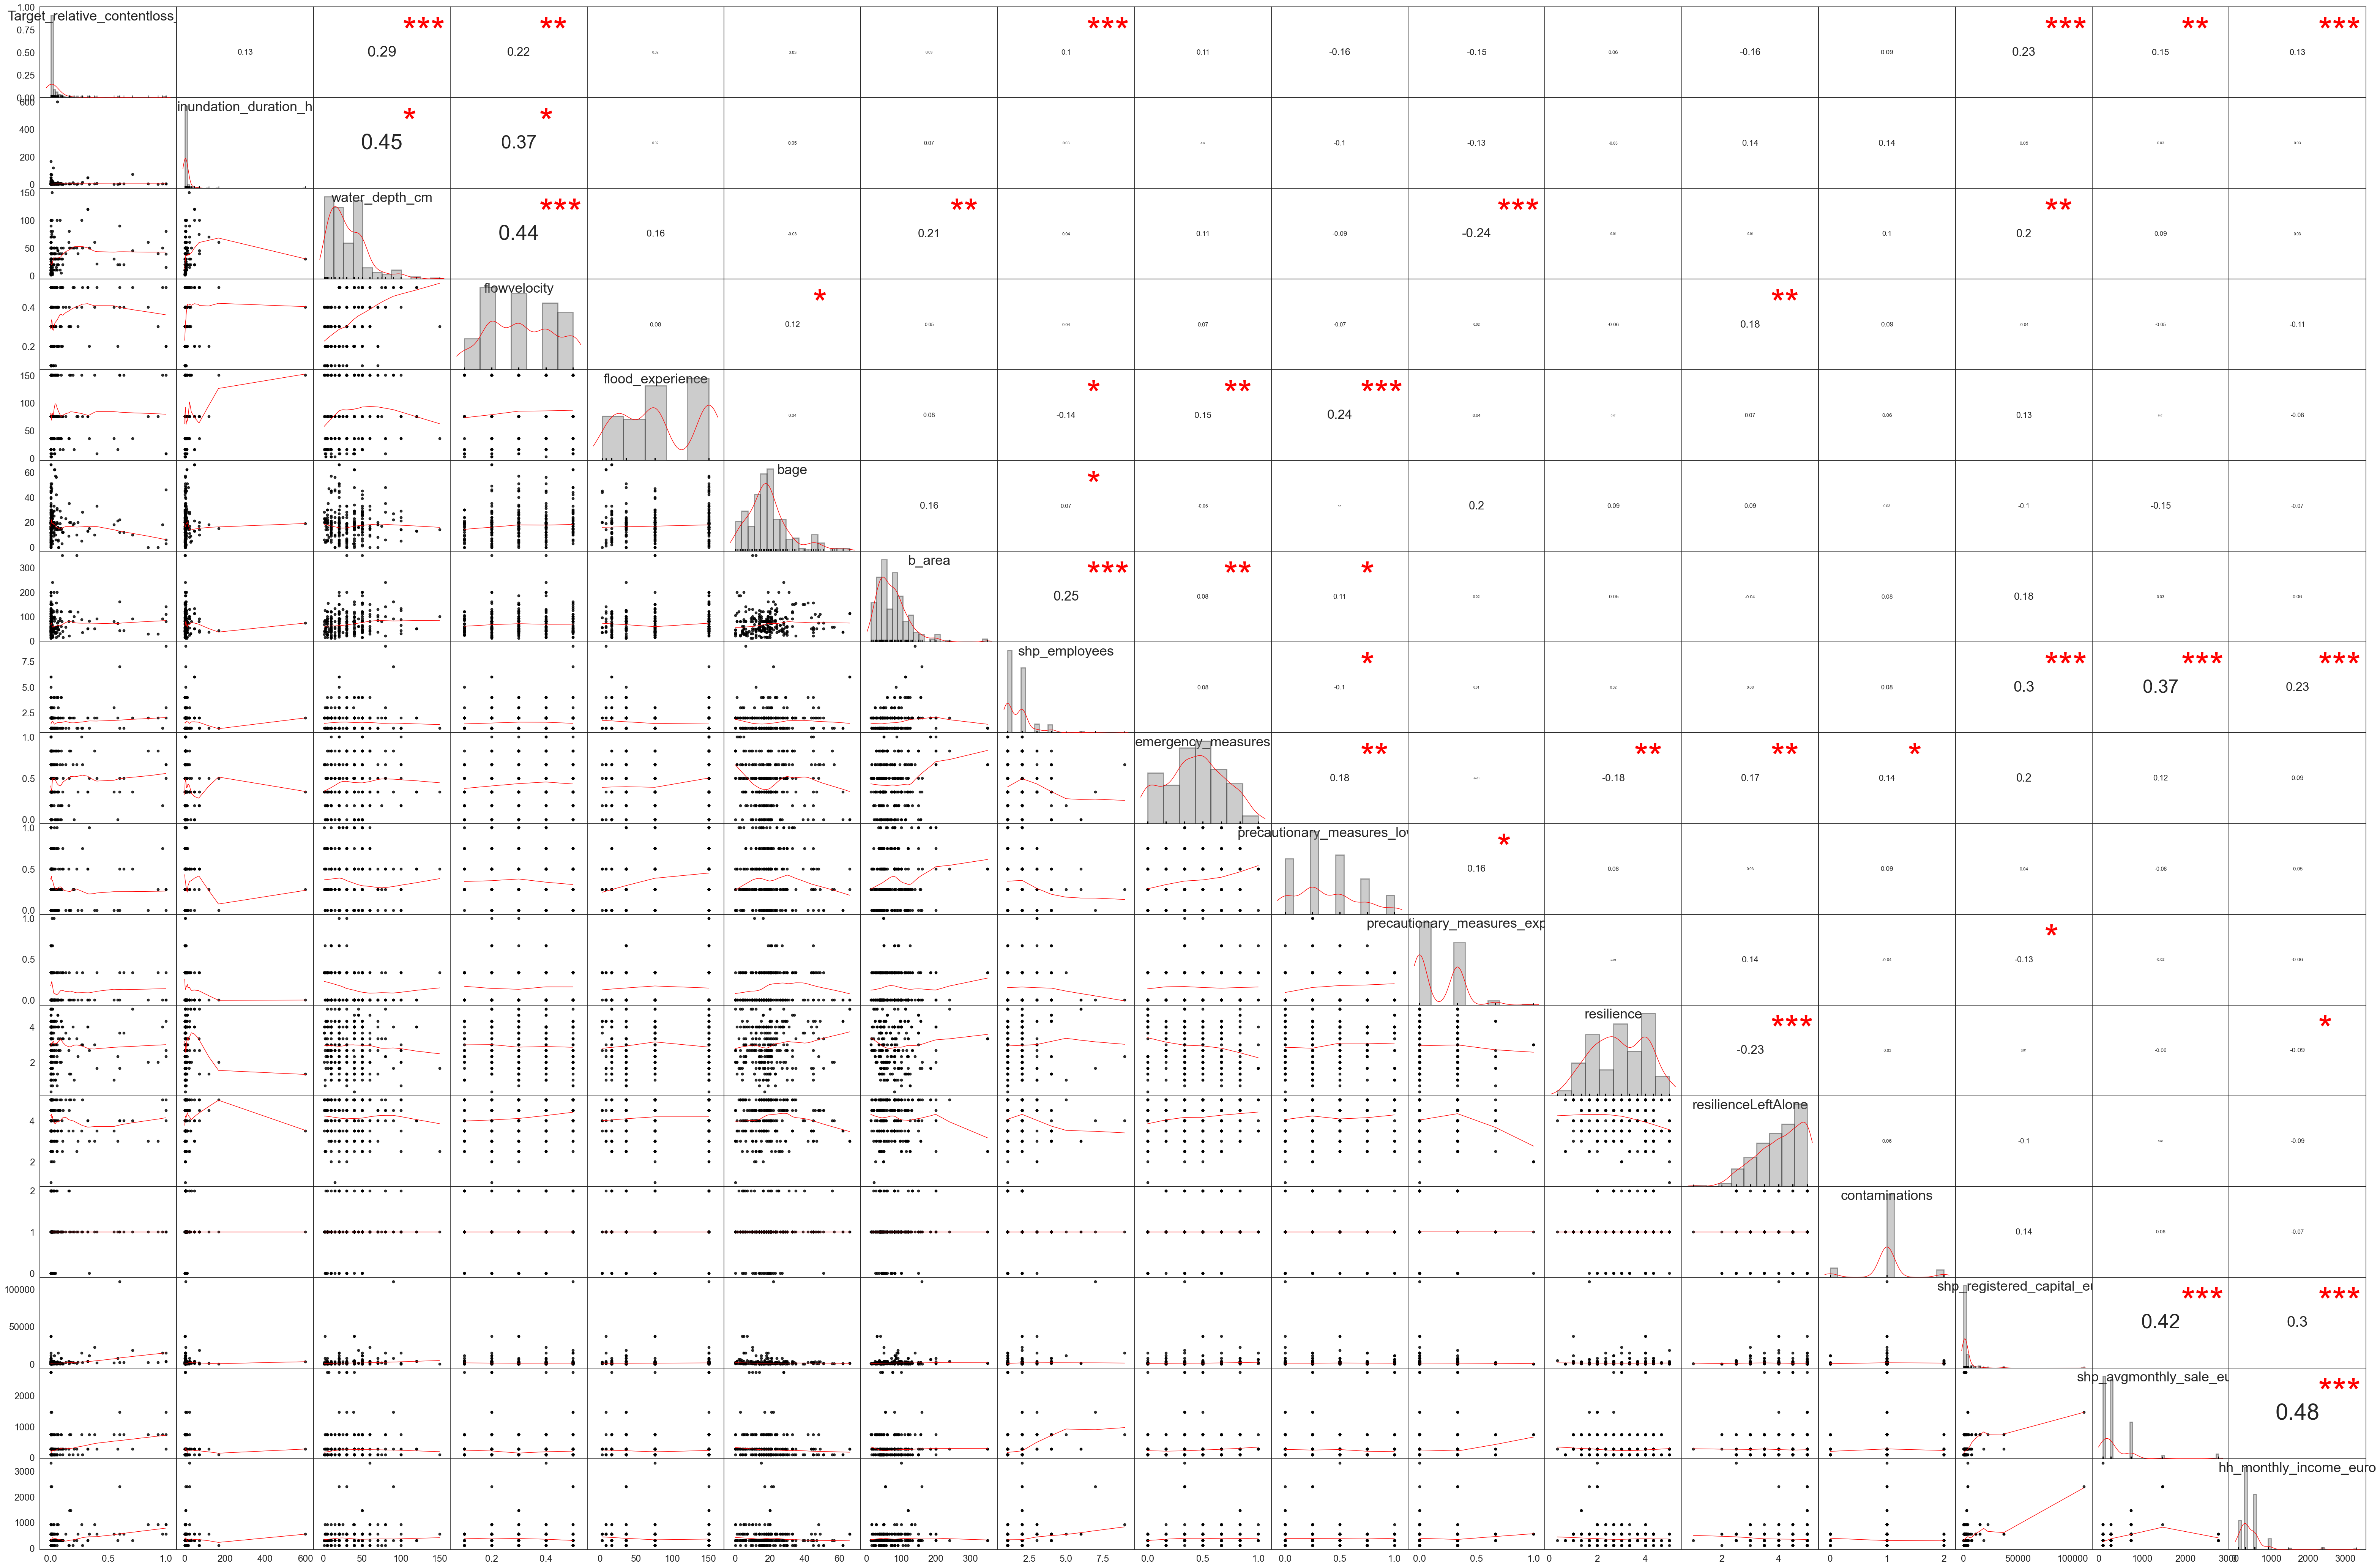

In [9]:
df = df_candidates
df = df.dropna()

# all_input["overall_problem_house"] = all_input["overall_problem_house"].apply(pd.to_numeric)
# all_input["contaminations"] = all_input["contaminations"].apply(pd.to_numeric)
## move targets to beginning
df.insert(0, "Target_relative_contentloss_euro", df.pop("Target_relative_contentloss_euro"))
# df = df.drop(["flood_type.1", "flood_type.2", "flood_type.3"], axis=1)

sns.set(style='white', font_scale=1.6)

g = sns.PairGrid(df, aspect=1.5, diag_sharey=False, despine=False)
g.map_lower(sns.regplot, lowess=True, ci=False,
            line_kws={'color': 'red', 'lw': 1},
            scatter_kws={'color': 'black', 's': 20})
g.map_diag(sns.distplot, color='black',
           kde_kws={'color': 'red', 'cut': 0.7, 'lw': 1},
           hist_kws={'histtype': 'bar', 'lw': 2, #'bins': 'auto', # 10
                     'edgecolor': 'k', 'facecolor':'grey'})
g.map_diag(sns.rugplot, color='black')
g.map_upper(corrdot)
g.map_upper(corrfunc)
g.fig.subplots_adjust(wspace=0, hspace=0)

# Remove axis labels
for ax in g.axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')

# Add titles to the diagonal axes/subplots
for ax, col in zip(np.diag(g.axes), df.columns):
    ax.set_title(col, y=0.82, fontsize=26)

In [ ]:
# # ### Test : remove / set to np.nan the two datapoints in abs loss which are very high
# sns.regplot(x=df.Target_contentloss_euro, y=df.shp_employees,
#     lowess=True, ci=False,
#     line_kws={'color': 'red', 'lw': 1},
#     scatter_kws={'color': 'black', 's': 20}
#     )

# # #sns.boxenplot(df.Target_contentloss_euro)
# # sns.boxenplot(df.Target_relative_contentloss_euro)
# # # sns.boxenplot(df.Target_businessreduction)
# # sns.boxenplot(df.shp_employees)


In [10]:
# df_candidates = df_candidates.loc[ ~(df_candidates.shp_registered_capital_euro >= 5000), :]
# df_candidates = df_candidates.loc[ ~(df_candidates.shp_registered_capital_euro >= 50000), :]
print(df_candidates.shape)
df_candidates.shp_registered_capital_euro.describe()
# df_candidates.shp_registered_capital_euro.hist(bins=50)

(389, 17)


count       342.000000
mean       3390.168129
std       10671.127672
min          36.800000
25%         368.300000
50%        1104.800000
75%        2209.500000
max      110476.900000
Name: shp_registered_capital_euro, dtype: float64

In [300]:
# df_candidates = df_candidates.loc[ ~(df_candidates.hh_monthly_income_euro >= 15000), :]
print(df_candidates.shape)
df_candidates.hh_monthly_income_euro.describe()


(295, 15)


count     293.000000
mean      207.666212
std       180.454961
min         9.200000
25%       128.900000
50%       128.900000
75%       276.200000
max      1841.300000
Name: hh_monthly_income_euro, dtype: float64

In [301]:
# df_candidates = df_candidates.loc[ ~(df_candidates.shp_employees >= 10), :]
print(df_candidates.shape)
df_candidates.shp_employees.describe()


(293, 15)


count    292.000000
mean       1.619863
std        1.125775
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        7.000000
Name: shp_employees, dtype: float64

In [ ]:
# df_candidates.loc[ ~(df_candidates.Target_relative_contentloss_euro >= 0.5), :].Target_relative_contentloss_euro.describe()

In [302]:
# ## test rloss <= 0.5 due that for HCMC also this imporved the alogrithm to ACc=60% - no improement for combi df when rloss only < 0.5
# #df_candidates = df_candidates.loc[ ~(df_candidates.Target_relative_contentloss_euro >= 1.0), :]
#df_candidates = df_candidates.loc[ ~(df_candidates.Target_relative_contentloss_euro >= 0.5), :]
print(df_candidates.shape)
df_candidates.Target_relative_contentloss_euro.describe()

# # TODO fix this in data:clenaing py2 -> eg test 1 ru with HCMC incl rloos > 0..5 
# # # or 1 run with cantho < 0.5

(293, 15)


count    293.000000
mean       0.104553
std        0.195608
min        0.000000
25%        0.000000
50%        0.000000
75%        0.105869
max        0.988414
Name: Target_relative_contentloss_euro, dtype: float64

In [ ]:
df_candidates.columns

Index(['Target_relative_contentloss_euro', 'inundation_duration_h',
       'water_depth_cm', 'flowvelocity', 'flood_experience', 'bage', 'b_area',
       'shp_employees', 'emergency_measures', 'precautionary_measures_lowcost',
       'precautionary_measures_expensive', 'resilience', 'resilienceLeftAlone',
       'contaminations', 'shp_registered_capital_euro',
       'shp_avgmonthly_sale_euro', 'hh_monthly_income_euro'],
      dtype='object')

<Axes: >

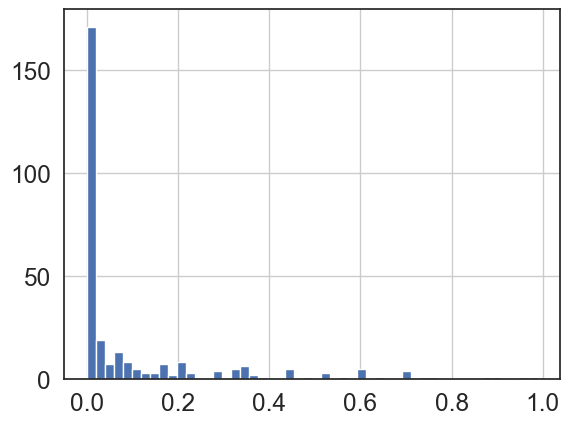

In [303]:
# df_candidates
df_candidates[target].hist(bins=50)

In [289]:
# df_candidates = df_candidates.loc[ ~(df_candidates[target]>0.5), :]
df_candidates[target].describe()

count    624.000000
mean       0.080021
std        0.180808
min        0.000000
25%        0.000000
50%        0.000000
75%        0.056912
max        1.000000
Name: Target_relative_contentloss_euro, dtype: float64

## Fit model

(389, 47)
Index(['shp_sector', 'flood_type', 'applied_emergency', 'emergency_1',
       'emergency_2', 'emergency_3', 'emergency_4', 'emergency_5',
       'emergency_6', 'emergency_7', 'emergency_8', 'emergency_9',
       'emergency_effect', 'wd', 'inud', 'contamination', 'fv',
       'overall_problem_building', 'contents_cost_repalce', 'precaution_1',
       'precaution_2', 'precaution_3', 'precaution_4', 'precaution_5',
       'precaution_6', 'precaution_7', 'Efficacy of adaptation measure',
       'Efficacy of adaptation measure.1', 'perception_1', 'perception_2',
       'perception_3', 'perception_4', 'perception_5', 'perception_6',
       'perception_7', 'perception_8', 'perception_9', 'perception_10', 'Year',
       'ownership', 'b_age', 'hh_income', 'Opened year', 'number_employees',
       'shp_avg_monthly_sale', 'b_area', 'Target_abs_loss'],
      dtype='object')

  ############### Applying LogisticRegression on Target_abs_loss:  ###############

Amount of missing target value

<Figure size 3000x2200 with 0 Axes>

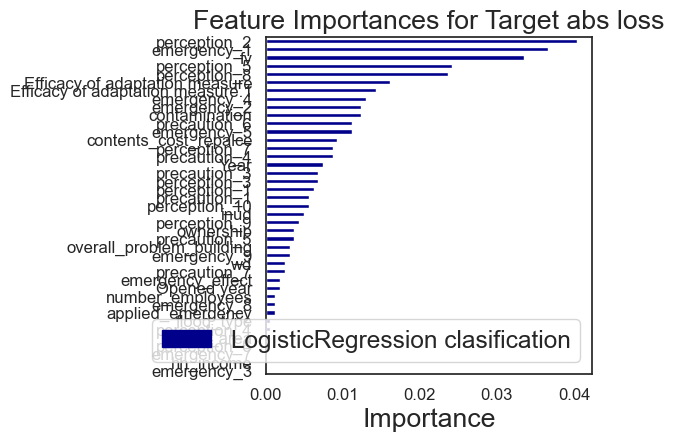

Dropping 0 records from entire dataset due that these values are nan in target variable
Keeping 322 records and 47 features
Index(['perception_2', 'emergency_1', 'fv', 'perception_5', 'perception_8',
       'Efficacy of adaptation measure', 'Efficacy of adaptation measure.1',
       'emergency_4', 'emergency_2', 'contamination', 'precaution_6',
       'emergency_5', 'contents_cost_repalce', 'perception_7', 'precaution_4',
       'Year', 'precaution_3', 'perception_3', 'perception_1', 'precaution_1',
       'perception_10', 'inud', 'perception_9', 'ownership', 'precaution_5',
       'overall_problem_building', 'emergency_9', 'wd', 'precaution_7',
       'emergency_effect', 'Opened year', 'number_employees', 'emergency_8',
       'applied_emergency', 'flood_type', 'perception_4', 'perception_6',
       'emergency_7', 'hh_income', 'b_area', 'emergency_3'],
      dtype='object')
total features: 47
dropped features: 6
selected 41 features: 
['perception_2', 'emergency_1', 'fv', 'perception_

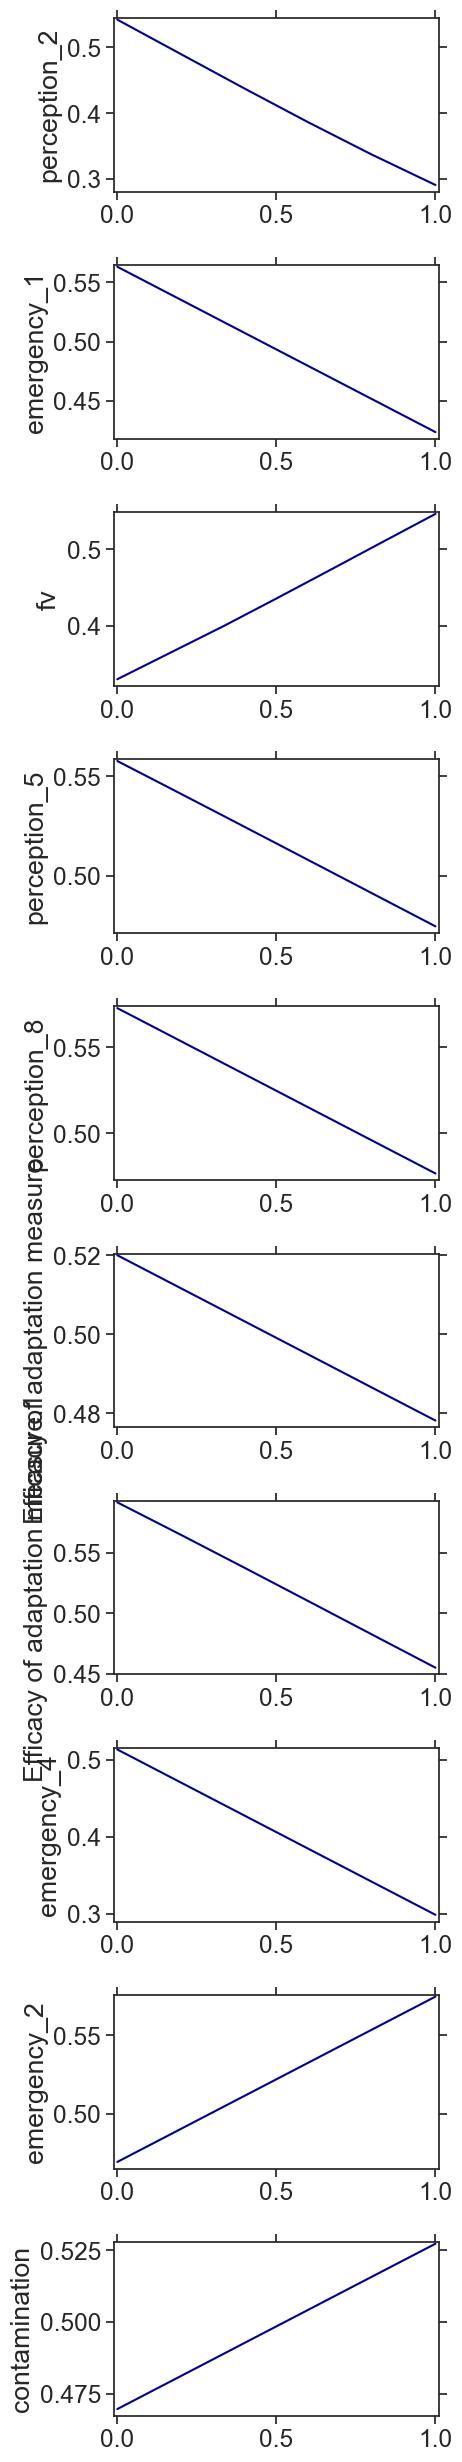

In [316]:
print(df_candidates.shape)



## Fit model

score_metrics = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1_macro": "f1_macro",
}

## test drop flow velocity due to diffenret flooding sources (eg. overwhelmed draingage systems)
# df_candidates = df_candidates.drop("flowvelocity", axis=1)
print(df_candidates.columns)

## iterate over piplines. Each pipline contains a scaler and regressor (and optionally a bagging method) 

# pipelines = ["pipe_logreg_bag"]
pipelines = ["pipe_logreg"]
#pipelines = ["pipe_sgd"] # with logreg loss and en penality

eval_sets = {}
models_trained = {}
final_models_trained = {}
models_coef = {}
predicted_values = {}
df_feature_importances = pd.DataFrame(index=df_candidates.drop(target, axis=1).columns.to_list())
models_scores = {}

## Load set of hyperparamters
hyperparams_set = pp.load_config("../../../utils/hyperparameter_sets.json")


for pipe_name in pipelines:

    TIME0 = datetime.now()

    ## load model pipeline and get model name
    pipe = joblib.load(f'../pipelines/{pipe_name}.pkl')

    try:
        model_name = re.findall("[a-zA-Z]+", str(pipe.steps[1][1].__class__).split(".")[-1])[0] # get model name for python models  
    except AttributeError:
        model_name = pipe # get R model name
    

    print( f"\n  ############### Applying {model_name} on {target}:  ###############\n")

    ## load hyperparameter space
    param_space = hyperparams_set[f"{model_name}_hyperparameters"]

    ## if bagging is used, adapt hyperparameeter names
    if "bag" in pipe_name.split("_"):
        print(f"Testing {model_name} with bagging")
        param_space = { k.replace('model', 'bagging__estimator') : v for (k, v) in param_space.items()}


    ## load input dataset
    df_Xy = df_candidates
    X_names = df_Xy.drop(target, axis=1).columns.to_list()

    # ## test impact of median imputation on model performance
    # print("test impact of median imputation on model performance")
    # df_Xy[X_names] = df_Xy[X_names].apply(lambda x: x.fillna(x.median()),axis=0)


    ## set target as binary class
    df_Xy[target][df_Xy[target] > 0] = 1
    df_Xy[target] = df_Xy[target].astype("Int64")

    ## clean df from remaining records containg nan
    df_Xy.dropna(inplace=True) ## TODO test with only nan in target removed

    print("Amount of missing target values should be zero: ", df_Xy[target].isna().sum())

    print(
        "Using ",
        df_Xy.shape[0],
        " records, from those are ",
        (df_Xy[target][df_Xy[target] == 0.0]).count(),
        " cases with zero-loss or zero-reduction",
    )

    X = df_Xy[X_names]
    y = df_Xy[target]



    if model_name != "crf":

        # ## save evaluation set for later usage in feature importance
        # eval_sets[f"{model_name}"] = df_Xy #pd.concat([df_Xy[target], X_crf], axis=1)         
        mf = t.ModelFitting(
            model=pipe, 
            Xy=df_Xy,
            target_name=target,
            param_space=param_space,
            tuning_score="f1_macro", #"precision", #"f1_macro", # accuracy
            cv=cv,
            kfolds_and_repeats=kfolds_and_repeats,
            seed=seed,
        )
        models_trained_ncv = mf.model_fit_ncv()  # pipe
        
        me = e.ModelEvaluation(
            models_trained_ncv=models_trained_ncv, 
            Xy=df_Xy,
            target_name=target,
            score_metrics=score_metrics,
            cv=cv,
            kfolds=kfolds_and_repeats[0],
            seed=seed,
        )
        model_evaluation_results = me.model_evaluate_ncv(prediction_method="predict_proba")


        ## visual check if hyperparameter ranges are good or need to be adapted
        for i in range(len(model_evaluation_results["estimator"])):
            print(f"{model_name}: ", model_evaluation_results["estimator"][i].best_params_)


        ## store models evaluation 
        models_scores[model_name] =  {
            k: model_evaluation_results[k] for k in tuple("test_" + s for s in list(score_metrics.keys()))
        } # get evaluation scores, metric names start with "test_<metricname>"


        ## Final model

        ## get final model based on best MAE score during outer cv
        best_idx = list(models_scores[model_name]["test_f1_macro"]).index(max(models_scores[model_name]["test_f1_macro"]))
        # best_idx = list(models_scores[model_name]["test_accuracy"]).index(max(models_scores[model_name]["test_accuracy"]))
        final_model = model_evaluation_results["estimator"][best_idx]
        print("used params for best model:", final_model.best_params_)  # use last model as the best one
        final_model = final_model.best_estimator_

        ## predict on entire dataset and save final model
        y_pred = final_model.predict(X) 
        final_models_trained[model_name] = final_model 
        joblib.dump(final_model, f"./models_trained/can_tho/chance_of_loss/final_models/{model_name}_{target}.joblib")

        ## Feature importance of best model
        importances = me.permutation_feature_importance(final_model, repeats=5)

        ## regression coefficients for linear models
        with contextlib.suppress(Exception):   # <-- better than: try and bare except

            models_coef[model_name] = me.calc_regression_coefficients(final_model)

            outfile = f"./models_evaluation/can_tho/chance_of_loss/regression_coefficients_{model_name}_{target}.xlsx"
            models_coef[model_name].round(3).to_excel(outfile, index=True)
            print("Regression Coefficients:\n", models_coef[model_name].sort_values("probabilities", ascending=False), f"\n.. saved to {outfile}")


    # filename = f'./models_trained_ncv/{model_name}_{target}.sav'
    # pickle.dump(model, open(filename, 'wb'))
    eval_sets[model_name] = df_Xy
    models_trained[f"{model_name}"] = models_trained_ncv
    # models_trained[model_name] = model_evaluation_results["estimator"]
    predicted_values[model_name] = me.residuals

    ## Feature importance
    print("\nSelect features based on permutation feature importance")
    df_importance = pd.DataFrame(
        {
            f"{model_name}_importances" : importances[0],   # mean importnaces across repeats
            f"{model_name}_importances_std" : importances[1]
        },
        index=X_names,
    )
    df_feature_importances = df_feature_importances.merge(
        df_importance[f"{model_name}_importances"],   # only use mean FI, drop std of FI
        left_index=True, right_index=True, how="outer")

    df_feature_importances = df_feature_importances.sort_values(f"{model_name}_importances", ascending=False)  # get most important features to the top
    print("5 most important features:", df_feature_importances.iloc[:5].index.to_list())
    #df_importance = df_importance.loc[df_importance[f"{model_name}_importances"] >= 0.000000, : ]

    print(
    f"\nTraining and evaluation of {model_name} took {(datetime.now() - TIME0).total_seconds()} seconds\n"
    )

# SDG without threshold: model performance measured in Accuracy (std) on outer CV: 0.583 (0.010)
# LogReg without median imputation - no model improvement
# LogReg without cases which had more than 1000€ absolute losses - no model improvement
# # LogReg with upper threshold of 2000 €: model performance measured in Accuracy (std) on outer CV: 0.598 (0.085)  
# LogReg with upper threshold of 2000 € without flowvelo: model performance measured in Accuracy (std) on outer CV: 0.581 (0.078)
# LogReg with upper threshold of 2000 € with f1_macro for model tuning: model performance measured in Accuracy (std) on outer CV:  0.594 (0.082)
# LogReg with upper threshold of 2000 € and only first 100 records: model performance measured in Accuracy (std) on outer CV: 0.644 (0.151)  

## Print model evaluation based on performance on outer cross-validation 
classifier_model_evaluation = pd.DataFrame(models_scores[model_name]).mean(axis=0)  # get mean of outer cv metrics (negative MAE and neg RMSE, pos. R2, pos MBE, posSMAPE)
classifier_model_evaluation_std = pd.DataFrame(models_scores[model_name]).std(axis=0)   # get respective standard deviations

model_evaluation = pd.concat([classifier_model_evaluation, classifier_model_evaluation_std], axis=1)
model_evaluation.columns = [f"{model_name}_score", f"{model_name}_score_std"]

model_evaluation.index = model_evaluation.index.str.replace("test_", "")

outfile = f"./models_evaluation/can_tho/chance_of_loss/performance_{target}.xlsx"
model_evaluation.round(3).to_excel(outfile, index=True)
print("Outer evaluation scores:\n", model_evaluation.round(3), f"\n.. saved to {outfile}")


## Feature Importances 
### drop features which dont reduce the loss
df_feature_importances_plot = df_feature_importances
df_feature_importances_plot = df_feature_importances_plot.loc[df_feature_importances_plot[f"{model_name}_importances"] >= 0.0000, : ] 
df_feature_importances_plot = df_feature_importances_plot.sort_values(f"{model_name}_importances", ascending=True)


## TODO update with plt_fi() func as soons a its more flexible in number of models passed to func()
plt.figure(figsize=(30, 22), facecolor="w")
fig = df_feature_importances_plot.plot.barh(
    color="darkblue",
    width=0.5,
    )
plt.xlabel("Importance")
plt.ylabel("")
plt.title(f"Feature Importances for {target.replace('_',' ')}")

top_bar = mpatches.Patch(color="darkblue", label=f"{model_name} clasification")
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.legend(handles=[top_bar], loc="lower right")
plt.tight_layout()
plt.grid(False)
plt.show()

 
fig.get_figure().savefig(f"./models_evaluation/can_tho/chance_of_loss/feature_importances_{target}.jpg", bbox_inches="tight")
plt.close()


# f.plot_stacked_feature_importances(
#     df_feature_importances_plot["LogisticRegression_importances"],
#     target_name=target,
#     model_names_plot = ("Logistic Regression"),
#     outfile=f"./models_evaluation/chance_of_loss/feature_importances_{target}.jpg"
# )


### Save final feature space 
## The final selection of features is used later for the non-parametric Bayesian Network

## drop records with missing target values
print(f"Dropping {df_candidates[f'{target}'].isna().sum()} records from entire dataset due that these values are nan in target variable")
df_candidates = df_candidates[ ~df_candidates[target].isna()]
print(f"Keeping {df_candidates.shape[0]} records and {df_candidates.shape[1]} features")


## sort features by their overall importance (weighted sum across across all features) 
final_feature_names = df_feature_importances_plot[f"{model_name}_importances"].sort_values(ascending=False).index##[:10]
print(final_feature_names)

## save importnat features, first column contains target variable
fs.save_selected_features(
    df_candidates, 
    pd.DataFrame(df_candidates, columns=[target]), 
    final_feature_names,
    filename=f"./selected_features/can_tho/chance_of_loss/final_predictors_{target}.xlsx"
)


### Partial dependence
## PDP shows the marginal effect that one or two features have on the predicted outcome.

## store partial dependences for each model
pdp_features = {a : {} for a in [model_name]}

for model_name in [model_name]:

    Xy_pdp = eval_sets[model_name].dropna() #  solve bug on sklearn.partial_dependece() which can not deal with NAN values
    X_pdp, y_pdp = Xy_pdp[Xy_pdp.columns.drop(target)], Xy_pdp[target]
    X_pdp = pd.DataFrame(
        MinMaxScaler().fit_transform(X_pdp), # for same scaled pd plots across models
        columns=X.columns
        )
    Xy_pdp = pd.concat([y_pdp, X_pdp], axis=1)

    for predictor_name in X.columns.to_list(): 
        features_info =  {
            #"percentiles" : (0.05, .95) # causes NAN for some variables for XGB if (0, 1)
            "model" : final_models_trained[model_name], 
            "Xy" : Xy_pdp, 
            "y_name" : target, 
            "feature_name" : predictor_name, 
            "scale"  : True
        }         
        # get Partial dependences for sklearn models
        partial_dep = me.get_partial_dependence(**features_info)

        pdp_features[model_name][predictor_name] = partial_dep


## Plot PDP

most_important_features = df_feature_importances_plot.sort_values(f"{model_name}_importances", ascending=False).index

categorical = [] # ["flowvelocity", "further_variables .."]
ncols = 1
nrows = len(most_important_features[:10])
idx = 0

plt.figure(figsize=(5,25))
# plt.suptitle(f"Partial Dependences for {target}", fontsize=18, y=0.95)


## create PDP for all three models
for feature in most_important_features[:10]:
    for model_name, color, idx_col in zip([model_name], ["darkblue"], [0]):
        
        # idx position of subplot
        ax = plt.subplot(nrows, ncols, idx + 1 + idx_col)
        feature_info = {"color" : color, "ax" : ax} 

        # plot
        df_pd_feature = pdp_features[model_name][feature]  
        p = f.plot_partial_dependence(
            df_pd_feature, 
            feature_name=feature, 
            partial_dependence_name="yhat", 
            categorical=[],
            outfile=f"./models_evaluation/can_tho/chance_of_loss/pdp_{target}.jpg",
            **feature_info
            )
        p

    idx = idx + 1


#plt.subplots_adjust(top=0.2)
plt.savefig(f"./models_evaluation/can_tho/chance_of_loss/pdp_{target}.jpg", bbox_inches="tight")


# ### Empirical median ~ predicted median
# Compare median and mean of predicted  vs observed target values
for k,v in predicted_values.items():
    print(f"\n{k}")
    print(em.empirical_vs_predicted(predicted_values[k]["y_true"], predicted_values[k]["y_pred"]))


# HCMC LogReg : with removed 4 highest abs loss removed ACC 0.61
#             LogisticRegression_score  LogisticRegression_score_std
# accuracy                       0.61                          0.08
# precision                      0.53                          0.10
# recall                         0.57                          0.15
# f1_macro                       0.59                          0.08 

## Can Tho
## drop in model performance when predict on abs loss (Acc 62%) --> r loss (Acc 0.55 - cv-selfbuilt)
# rloss limit to <= 0.5 - ACC 0.535

## HCMC
# with new cv estimation and rloss <= 0.5  : ACC - 0.60
# LogReg : with removed 4 highest ab loss (old cv apporach) removed ACC 0.61

## HCMC_cantho quick rm
# Outer evaluation scores:
#             LogisticRegression_score  LogisticRegression_score_std
# accuracy                       0.52                          0.04
# precision                      0.48                          0.03
# recall                         0.69 **-)                      0.11
# f1_macro                       0.51                          0.06 

,No,shp_sector,Unnamed: 2,Unnamed: 3,flood_experience,flood_type,warning_time,applied_emergency,emergency_1,emergency_2,emergency_3,emergency_4,emergency_5,emergency_6,emergency_7,emergency_8,emergency_9,emergency_effect,wd,inud,contamination,fv,overall_problem_building,contents_cost_repalce,Target_eloss,Target_gloss,Target_bred,precaution_1,precaution_2,precaution_3,precaution_4,precaution_5,precaution_6,precaution_7,Efficacy of adaptation measure,Efficacy of adaptation measure.1,perception_1,perception_2,perception_3,perception_4,perception_5,perception_6,perception_7,perception_8,perception_9,perception_10,Year,ownership,b_age,building_value,hh_income,Opened year,number_employees,shp_avg_monthly_sale,cv_goods,cv_equipment,b_area,floors,distance_to_river,b_elevation,b_type,Direct_damage
0,1,2.0,NaN,NaN,5.0,2.0,3.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,40.0,3.0,1.0,5.0,0.0,1500000.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,6.0,2.0,5.0,5.0,5.0,0.0,1.0,1.0,5.0,5.0,10.0,1.0,6.0,3.0,4.0,2004.0,1.0,20000000.0,1000000.0,1000000.0,60.0,1.0,100.0,1.0,4.0,3000000.0
1,2,4.0,NaN,NaN,5.0,3.0,7.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,5.0,30.0,3.0,1.0,6.0,0.0,0.0,500000.0,0.0,50.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,3.0,5.0,5.0,1.0,5.0,6.0,6.0,1.0,1.0,1.0,6.0,1.0,5.0,1.0,5.0,7.0,5.0,2007.0,3.0,15000000.0,100000000.0,10000000.0,31.5,0.0,1000.0,0.0,4.0,10500000.0
2,3,2.0,NaN,NaN,5.0,2.0,3.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,20.0,3.0,1.0,5.0,0.0,0.0,0.0,0.0,50.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,3.0,5.0,2.0,5.0,5.0,5.0,0.0,1.0,1.0,5.0,5.0,30.0,1.0,6.0,2.0,5.0,2000.0,1.0,15000000.0,2000000.0,500000.0,20.0,1.0,300.0,0.0,4.0,300000.0
3,4,2.0,NaN,NaN,5.0,3.0,7.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,40.0,4.0,1.0,4.0,0.0,0.0,0.0,0.0,50.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,6.0,6.0,1.0,6.0,5.0,6.0,0.0,1.0,1.0,6.0,4.0,28.0,1.0,6.0,5.0,4.0,1985.0,2.0,3000000.0,1000000.0,3000000.0,49.0,0.0,500.0,0.0,2.0,20000000.0
4,5,1.0,NaN,NaN,1.0,1.0,3.0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,20.0,1.0,4.0,4.0,0.0,0.0,0.0,120000.0,10.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,4.0,6.0,1.0,5.0,5.0,5.0,2.0,1.0,1.0,1.0,6.0,1.0,4.0,1.0,7.0,8.0,5.0,2000.0,1.0,1500000.0,8000000.0,2000000.0,100.0,1.0,250.0,0.0,4.0,720000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
385,386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
386,387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
387,388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
model_coef[f"LogisticRegression_selfbuilt"]["features"] =  ["intercept"] + X.columns.to_list()
model_coef[f"LogisticRegression_selfbuilt"]

NameError: name 'X' is not defined

In [ ]:
# models_cv_result.keys()

NameError: name 'models_cv_result' is not defined

In [ ]:
## scoring=ACC 5*5 ACC:
# outer CV: ACC: 0.573 (0.087)
# outer CV: precision: 0.491 (0.105)
# outer CV: recall: 0.607 (0.176)
# outer CV: F1: 0.529 (0.114)

## scoring=ACC 10*5 ACC: 

In [ ]:
# ValueError: Classification metrics can't handle a mix of binary and continuous targets
predicted_probabilities
#pd.Series(y_pred).describe()
# from sklearn.metrics import classification_report
print(classification_report(predicted_probabilities["y_empirical"], predicted_probabilities["y_pred_value"])) # baggin: ACC: 0.58
              

              precision    recall  f1-score   support

         0.0       0.68      0.59      0.63       153
         1.0       0.53      0.62      0.57       114

    accuracy                           0.61       267
   macro avg       0.61      0.61      0.60       267
weighted avg       0.62      0.61      0.61       267



In [ ]:
#logistic_reg_cv
# ?logistic_reg
# ?KFold
predicted_probabilities

## use continous  probability values for weights in BN
# --> gives chance that a certain vlaue of loss occures 
## model bias over/underestimation of losses


,y_empirical,y_pred_value,y_pred_value_proba
0,0,1,0.547010
1,0,1,0.602796
2,0,0,0.771077
4,0,0,0.615087
5,0,0,0.756869
...,...,...,...
385,0,1,0.549029
386,0,1,0.586166
387,0,1,0.553343
388,0,1,0.503891


In [ ]:
model_coef["LogisticRegression_selfbuilt"]["features"] =  ["intercept"] + X.columns.to_list()
model_coef["LogisticRegression_selfbuilt"].sort_values("features")

,Coefficients,Standard Errors,t values,Probabilities,features
6,0.1823,0.001,243.430,0.00000,b_area
5,0.0361,0.004,8.996,0.00000,bage
13,0.2134,0.120,1.778,0.07658,contaminations
10,0.3851,0.193,1.994,0.04721,emergency_measures
4,-0.0614,0.001,-63.443,0.00000,flood_experience
3,0.7565,0.436,1.734,0.08413,flowvelocity
9,0.4937,0.005,90.415,0.00000,hh_monthly_income
0,-0.8673,0.223,-3.888,0.00013,intercept
1,0.1942,0.001,165.652,0.00000,inundation_duration_h
14,0.6270,0.028,22.411,0.00000,overall_problem_house


In [ ]:
model_coef["logreg_freg"].sort_values("features")

KeyError: 'logreg_freg'

## Evaluation

#### Coefficients of Logistic Regression 

LogReg:  The algorithm estimates the probability of an event occurring by fitting a logistic function to a set of input variables. The coefficients for logistic regression are used to measure the strength of the relationship between the input variables and the output variable.
LogReg doesnt reduce the influence of correlated variables on the model (in contrast to the rregularization termo of Linear models.)

[https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#checking-the-variability-of-the-coefficients]


sklearn:
odds_ratio = exp(coef)
where exp is the exponential function and coef is the coefficient for the input variable. The odds_ratio represents the change in the odds of the output variable for a one-unit increase in the input variable. A value greater than 1 indicates that the odds of the output variable increase with an increase in the input variable

In [ ]:
model_coef["logreg_selfbuilt"]["features"] =  ["intercept"] + X.columns.to_list()
model_coef["logreg_selfbuilt"].sort_values("features")


,Coefficients,Standard Errors,t values,Probabilities,features
6,0.2446,0.001,341.864,0.00000,b_area
5,0.1925,0.004,49.143,0.00000,bage
14,0.3394,0.114,2.966,0.00332,contaminations
11,0.4738,0.189,2.504,0.01296,emergency_measures
4,-0.0147,0.001,-15.279,0.00000,flood_experience
3,0.6637,0.422,1.573,0.11694,flowvelocity
10,0.7113,0.005,135.395,0.00000,hh_monthly_income
0,-0.9006,0.230,-3.915,0.00012,intercept
1,0.1944,0.001,173.376,0.00000,inundation_duration_h
15,0.7486,0.027,27.741,0.00000,overall_problem_house


In [ ]:
#df_candidates.resistant_material_building_impl.value_counts()

AttributeError: 'DataFrame' object has no attribute 'resistant_material_building_impl'

In [ ]:
model_coef["logreg_selfbuilt"].sort_values("features")

,Coefficients,Standard Errors,t values,Probabilities,features
13,0.2246,0.001,294.144,0.00000,b_area
12,0.1489,0.004,35.504,0.00000,bage
19,0.4048,0.122,3.321,0.00104,contaminations
9,-0.2709,0.031,-8.773,0.00000,electricity_higher_impl
7,0.4930,0.032,15.528,0.00000,elevation_building_impl
18,0.2083,0.208,1.004,0.31662,emergency_measures
11,-0.0781,0.001,-72.531,0.00000,flood_experience
10,-0.5034,0.087,-5.783,0.00000,flood_protections_impl
3,0.8193,0.453,1.809,0.07178,flowvelocity
17,0.5616,0.006,99.361,0.00000,hh_monthly_income


In [ ]:
# #models_trained["LogisticRegression"]
# #print(model_coef.keys())
# #model_coef

# import statsmodels.api as sm

# df_candidates_sm = pd.get_dummies(df_candidates_t, columns=[target], drop_first=True)
# y_sm = df_candidates_sm[[target+"_1"]]
# X_sm = df_candidates_sm.drop(target+"_1", axis=1)
# sm_model = sm.Logit(y_sm, sm.add_constant(X_sm)).fit(disp=0)
# print(sm_model.pvalues)
# sm_model.summary()




In [ ]:
# #import statsmodels.api as sm

# print(model_coef.keys())
# print(model_coef["LogisticRegression"].sort_values("coef", key=abs, ascending=False).head(10))

## Interpretation of coefficients:
#  Without normalization: e.g increase of 1 year in AGE means a decrease of <coef_value> of the target in its unit, 
#  On the other hand, categorical variables (as UNION or SEX) are adimensional numbers taking either the value 0 or 1 (<-were hot-encoded). 
# Their coefficients are expressed in dollars/hour. Then, we cannot compare the magnitude of different coefficients since the features 
# have different natural scales, and hence value ranges, because of their different unit of measure. 
# [https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#checking-the-variability-of-the-coefficients]

### Confusion matrix

,0,1
0,68,82
1,35,74


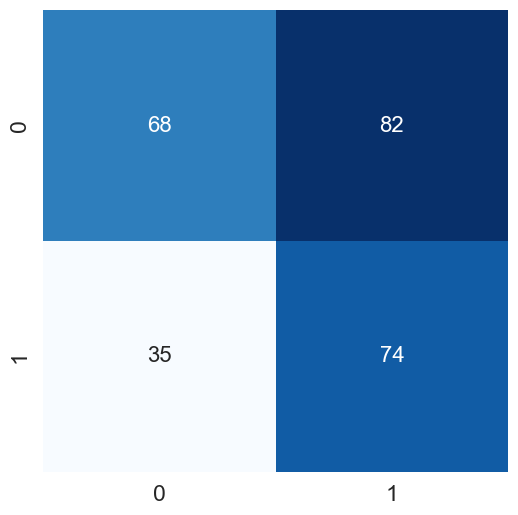

In [ ]:
## based on neste cv
f.plot_confusion_matrix(
    predicted_values["y_pred"],
    predicted_values["y_pred"],
    show_absolute=True,
    show_normed=True,
    colorbar=False,
    model_name="Logistic_Regression", target_name=target)

### Empirical median ~ predicted median

And further statitics compared to their empirical counterpart.
-  mean / variance / std  compared to empirical distribution

In [ ]:
# print("Logistic Reg (binary classification): ", target)
# e.empirical_vs_predicted(
#     X, y.astype(int),
#     models_list=[final_models_trained["LogisticRegression"].named_steps["model"]]    
#     #models_list=[model, model_log, model_quantile, model_boxcox, model_sqrt]    
# )

# ## TODO idea: make a median/mean etc of best model as boxplots 8one (3 models for each target)


Logistic Reg (binary classification):  Target_relative_contentloss_euro


IndexError: list index out of range

In [ ]:
# #scores = cross_validate(elastic_net, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# #pd.DataFrame(scores).set_index("test_score").sort_index().T

# # #Snippet from: https://ubc-cs.github.io/cpsc330/lectures/08_hyperparameter-optimization.html#exhaustive-grid-search-sklearn-model-selection-gridsearchcv
# #pd.DataFrame(elastic_net_cv.cv_results_).set_index("rank_test_score").sort_index().T
# pd.DataFrame(model.cv_results_)[
#         [                                   # only important cv evaluation metrics 
#             "mean_test_score",
#             "mean_fit_time",
#             "rank_test_score",
#             "param_name__estimator__C",
#             "param_name__estimator__penalty",
#             "param_name__estimator__l1_ratio",
#             "param_name__estimator__max_iter"
#         ]
#     ].set_index("rank_test_score").sort_index().T


AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [ ]:
## reload models

print(targets)
target = targets[0]

logistic_reg_eval = pickle.load(open(f"./models_trained/logisticreg_{target}.sav", 'rb'))
#elastic_net_eval.get_params()


['Target_contentloss_euro', 'Target_businessreduction']


### Feature importance

In [ ]:
## TODO test to get std of FI _ C:\Users\Anna\Documents\UNI\MA_topic\recycling\sm2t-traffic-speed-model-partial-dependence\SM2T\sm2t-traffic-speed-model_partialDep\traffic_speed_model\modelling.py
#    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)  # based on RF_fi_ 

#plt.rcParams['axes.grid'] = 'none'
#s = df_feature_importances

<Figure size 3000x2200 with 0 Axes>

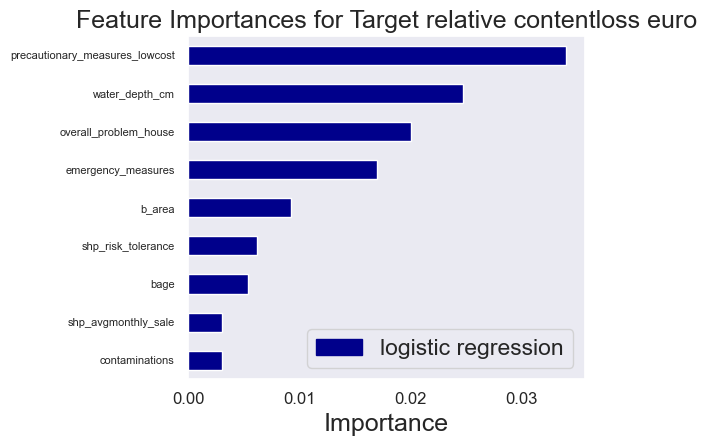

In [ ]:
### drop features which dont reduce the loss
#df_feature_importances = s
df_feature_importances = df_feature_importances.loc[df_feature_importances.logreg_importances >= 0.0001, : ] 
df_feature_importances = df_feature_importances.sort_values("logreg_importances", ascending=True)

plt.figure(figsize=(30, 22), facecolor="w")
df_feature_importances.plot.barh(
    color="darkblue",
    width=0.5,
    # #errorbar="sd",
    # errorbar=("pi", 50), 
    # capsize=.1, errcolor=".5",
    # linewidth=3,
    )
plt.xlabel("Importance")
plt.ylabel("")
plt.title(f"Feature Importances for {target.replace('_',' ')}")


top_bar = mpatches.Patch(color="darkblue", label="logistic regression")
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=8)
plt.legend(handles=[top_bar], loc="lower right")
plt.tight_layout()
#plt.axes().set_facecolor("w")
plt.grid(False)
#plt.show()

#sns.despine(left=True, bottom=True)
## save importance scores and figure
#filepath = f'./models_evaluation/best_xgb_importance_scores_{target}_{pipe_name}'
#if not glob(filepath):
#    df_importance.to_csv(filename, index = False)
#plt.savefig(f'../../../figures/best_en_feature_importance_{target}_{pipe_name}.png', bbox_inches='tight')



###  Partial dependences

In [ ]:
## store partial dependences for each classification algorithm

pdp_features = {a : {} for a in ["LogisticRegression"]}

me = e.ModelEvaluation()


for model_name in ["LogisticRegression"]:

    Xy_pdp = eval_sets[model_name].dropna() #  solve bug on sklearn.partial_dependece() which can not deal with NAN values
    X_pdp, y_pdp = Xy_pdp[Xy_pdp.columns.drop(target)], Xy_pdp[target]
    X_pdp = pd.DataFrame(
        MinMaxScaler().fit_transform(X_pdp), # for same scaled pd plots across models
        columns=X.columns
        )
    Xy_pdp = pd.concat([y_pdp, X_pdp], axis=1)

    for predictor_name in X.columns.to_list(): 
        features_info =  {
            #"percentiles" : (0.05, .95) # causes NAN for some variables for XGB if (0, 1)
            "model" : final_models_trained[model_name], 
            "Xy" : Xy_pdp, 
            "y_name" : target, 
            "feature_name" : predictor_name, 
            "scale"  : True
        }         

        if model_name != "crf":   
            print(predictor_name)
            partial_dep = me.get_partial_dependence(
                **features_info
            )
        else:  # process R models
            print("crf: ", predictor_name)
            partial_dep = me.decorator_func(       #  change function only temporally        
                # model=final_models_trained[model_name], 
                # Xy=Xy_pdp, 
                # y_name=target, 
                # feature_name=predictor_name, 
                # scale=True
                **features_info
            ) (me.get_partial_dependence)()

        pdp_features[model_name][predictor_name] = partial_dep



Exception ignored from cffi callback <function _callback at 0x0000029F3855F5E0>:
Traceback (most recent call last):
  File "c:\Anaconda\envs\py396_c3\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 329, in _callback
    try:
KeyboardInterrupt: 
Exception ignored from cffi callback <function _callback at 0x0000029F3855F5E0>:
Traceback (most recent call last):
  File "c:\Anaconda\envs\py396_c3\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 329, in _callback
    try:
KeyboardInterrupt: 


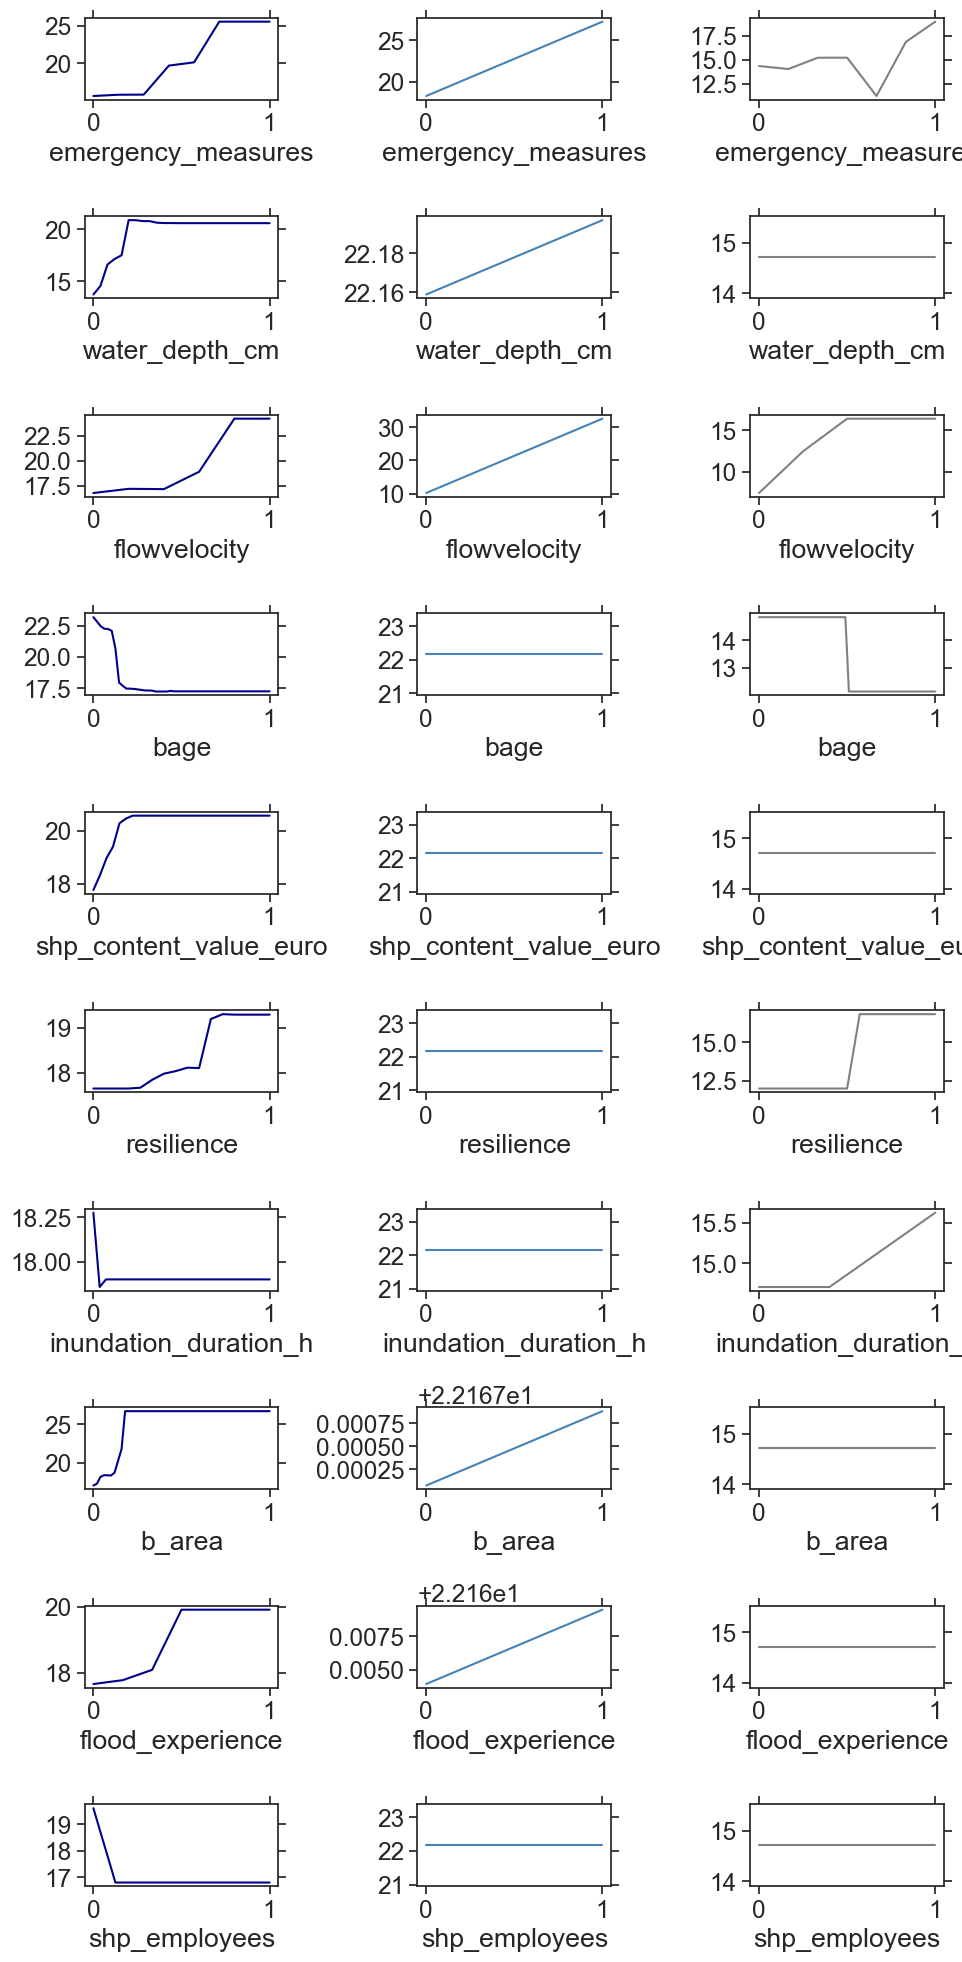

In [ ]:
plt.figure(figsize=(10,25))
#plt.subplots_adjust(hspace=0.9)
#plt.suptitle(f"Partial Dependences for {target}", fontsize=18, y=0.95)


most_important_features = df_feature_importances_plot.sort_values("sum_all_importances_weighted", ascending=False).index



idx = 0
categorical = [] # ["flowvelocity"]
ncols = 3
nrows = len(most_important_features[:10])

## create PDP for all three models
for feature in most_important_features[:10]:
    for model_name, color, idx_col in zip(["crf", "en", "xgb"], ["darkblue", "steelblue","grey"], [0, 1, 2]):
        
        # idx position of subplot
        ax = plt.subplot(nrows, ncols, idx + 1 + idx_col)
        feature_info = {"color" : color, "ax" : ax} 

        # plot
        df_pd_feature = pdp_features[model_name][feature]  
        p = f.plot_partial_dependence(
            df_pd_feature, feature_name=feature, partial_dependence_name="yhat", 
            categorical=[],
            outfile=f"./models_evaluation/chance_of_loss/pdp_{target}.jpg",
            **feature_info
            )
        p

    idx = idx + 3

#plt.subplots_adjust(top=0.2)
#plt.savefig("test_pdp.jpg", bbox_inches="tight")
